# utility

> Some utility

In [ ]:
#| default_exp utility

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
import fastcore as fc

In [ ]:
#| export
def to_categorical(x, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.

    E.g. for use with `categorical_crossentropy`.

    Args:
        x: Array-like with class values to be converted into a matrix
            (integers from 0 to `num_classes - 1`).
        num_classes: Total number of classes. If `None`, this would be inferred
            as `max(x) + 1`. Defaults to `None`.

    Returns:
        A binary matrix representation of the input as a NumPy array. The class
        axis is placed last.

    Example:

    >>> a = to_categorical([0, 1, 2, 3], num_classes=4)
    >>> print(a)
    [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]
    """
    x = np.array(x, dtype="int64")
    input_shape = x.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    x = x.reshape(-1)
    if not num_classes:
        num_classes = np.max(x) + 1
    batch_size = x.shape[0]
    categorical = np.zeros((batch_size, num_classes))
    categorical[np.arange(batch_size), x] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [ ]:
#| test
to_categorical([0, 1, 2, 3], num_classes=4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
#| export


class OverlapChunkTest1:
	
	def __init__(self, time_delay):
		self.chunk= 0
		self.output_size = 8
		self.counter = -1
		self.time_delay = time_delay
		self.time_counter = time_delay
		self.output_class= 0
		self.previous_output_class= None

		self.sequenceA_length = 4
		self.sequenceB_length = 4 #np.random.randint(2)+5
		self.previous_previous_output_class= None
	
	def getOutputSize(self):
		return self.output_size
	
	def trueLabel(self):
		truelabel= np.array((0,0,0,1,1,2,2,2))  # label of features
		return truelabel

	def updateTimeDelay(self):
		self.time_counter+= 1
		if self.time_counter > self.time_delay:
			self.time_counter = 0 
			return True
		else:
			return False

	#create an input pattern for the system
	def getInput(self, reset = False):
		
		if reset == True:
			self.chunk=0
			self.counter=-1

		update = self.updateTimeDelay()

		if update == True:
			if self.chunk == 0:
				if self.counter > self.sequenceA_length:
					self.chunk = 1
					self.counter= 0
				else:
					self.counter+= 1
			else:
				if self.counter > self.sequenceB_length:
					#self.sequenceB_length = np.random.randint(20)+5
					self.chunk = 0
					self.counter= 0
				else:
					self.counter+= 1

			if self.chunk == 0:
				#input_value = np.random.randint(10)
				#input_value= self.counter
				self.previous_previous_output_class= self.previous_output_class
				self.previous_output_class= self.output_class
				
				#possible outputs are 0,1,2,3,4
				self.output_class = np.random.randint(5)  
			else:
				self.previous_previous_output_class= self.previous_output_class
				self.previous_output_class= self.output_class
				#possible outputs are 3,4,5,6,7
				self.output_class = 3 + np.random.randint(5)

		noise_intensity= 0.0
		#input_value = np_utils.to_categorical(self.output_class, self.output_size) + np.random.randn(self.output_size)*noise_intensity
		if self.previous_output_class is None or self.previous_output_class == self.output_class:  # 上一个else
			input_value = to_categorical(self.output_class, self.output_size)*np.exp(-0.1*self.time_counter) + np.random.randn(self.output_size)*noise_intensity # input encoding (2)
		else:
			input_value = to_categorical(self.output_class, self.output_size)*np.exp(-0.1*self.time_counter) + np.random.randn(self.output_size)*noise_intensity + to_categorical(self.previous_output_class, self.output_size)*np.exp(-0.1*(self.time_counter+self.time_delay))
			# 对以一个刚转移完的态，加上上一个态的编码

		return input_value

	def getSequence(self, iterations):
		input_class = np.empty(iterations)
		input_sequence = np.empty((iterations, self.output_size))

		for i in range(iterations):
			input_value = self.getInput()
			#input_class.append(self.chunk)
			#input_sequence.append(input_value)
			input_class[i] = self.chunk
			input_sequence[i] = input_value
		


		return input_sequence, input_class

	def plot(self, input_class, input_sequence = None, save = False):
		
		a = np.asarray(input_class)
		t = [i for i,value in enumerate(a)]

		plt.plot(t, a)
	
		if input_sequence is not None:
			sequence = [np.argmax(x) for x in input_sequence]
			plt.plot(t, sequence)

		if save == True:
			plt.savefig("plot.png")
		
		plt.show()
		plt.close()
	
	def plotSuperposed(self, input_class, input_sequence = None, save = False):
		warnings.warn("please use `plot_encoded_data` instead", category=DeprecationWarning)
		input_sequence= np.asarray(input_sequence)
		
		t = [i for i,value in enumerate(input_sequence)]

		print(input_sequence.shape)

		#exit()

		for i in range(input_sequence.shape[1]):
			a = input_sequence[:,i]
			plt.plot(t, a, "*-")
		
		a = np.asarray(input_class)
		plt.plot(t, a, "*-")

		if save == True:
			plt.savefig("plot.png")
		
		plt.show()
		plt.close()

		

In [ ]:
#| test
time_delay = 10
env = OverlapChunkTest1(time_delay)
output_size = env.getOutputSize()
output_size

8

In [ ]:
sequence_length = 100000
input_sequence, input_class = env.getSequence(sequence_length)
input_sequence.shape, input_class.shape

((100000, 8), (100000,))

(200, 8)


/tmp/ipykernel_197729/4285883311.py:115: DeprecationWarning: please use `plot_encoded_data` instead
  warnings.warn("please use `plot_encoded_data` instead", category=DeprecationWarning)


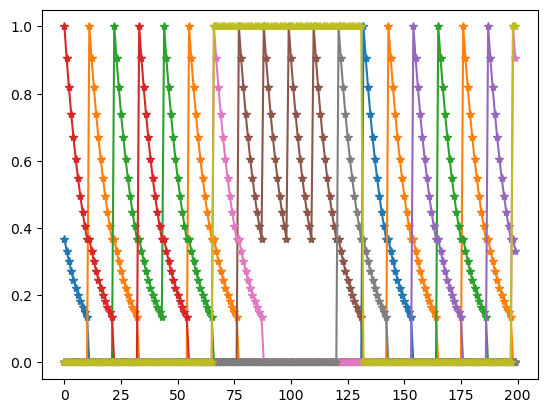

In [ ]:
# plot the encoded data
env.plotSuperposed(input_class[:200], input_sequence[:200])

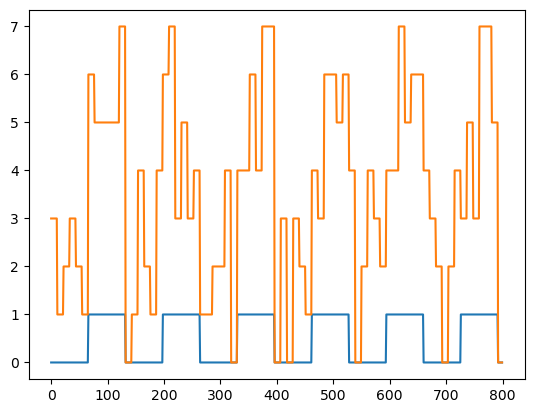

In [ ]:
# plot input data and labels
env.plot(input_class[:800], input_sequence[:800])

In [ ]:
#| export
def compute_combi_dist(data:np.ndarray)->np.ndarray:
    '''
    Compute the distance between all rows of the matrix.
    args:
        data: np.ndarray, shape (n_samples, n_features)
    return:
        np.ndarray, shape (n_samples)
    '''
    n_samples = data.shape[0]
    dist = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            dist[i, j] = np.linalg.norm(data[i] - data[j])
    return dist

In [ ]:
#| test
data = np.random.randn(5, 3)
compute_combi_dist(data)

array([[0.        , 1.50131585, 1.40853523, 0.81344457, 0.83503978],
       [1.50131585, 0.        , 1.87416187, 1.66236748, 1.40749348],
       [1.40853523, 1.87416187, 0.        , 1.07741412, 2.15643909],
       [0.81344457, 1.66236748, 1.07741412, 0.        , 1.49408485],
       [0.83503978, 1.40749348, 2.15643909, 1.49408485, 0.        ]])

## plotly for visualization

In [ ]:
#| export
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# @fc.patch


In [ ]:
input_sequence.shape

(100000, 8)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()